In [1]:
import glob
import math
import random
from typing import Callable, Union, Optional

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import pyplot as plt
import networkx as nx
from scipy.spatial import distance as distance_calculator
import torch
from torch import Tensor
from torch_geometric import nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv, global_max_pool, GATConv
import torch.nn.functional as F
from torch_geometric.typing import PairTensor, OptTensor
from torch_geometric.utils import scatter, to_networkx, add_self_loops
import seaborn as sn
from torch.nn import Sequential as Seq, Linear as Lin, Dropout, ReLU, BatchNorm1d as BN
from torch_geometric.nn.conv import MessagePassing
from torch_multi_head_attention import MultiHeadAttention
import torch_scatter
from torch_cluster import knn

In [2]:
random.seed(42)
column_names=['range','azimuth','doppler','snr','y','x','current_frame','seq']

features0: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/0/0/*.csv")])
features0.insert(8, "Label", np.zeros(len(features0), dtype=int), True)
max_frame = max(features0["current_frame"])

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.ones(len(features1), dtype=int), True)
min_frame = min(features1["current_frame"])
shift = max_frame-min_frame+10
features1["current_frame"] += shift
max_frame = max(features1["current_frame"])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 2, dtype=int), True)
min_frame = min(features2["current_frame"])
shift = max_frame-min_frame+10
features2["current_frame"] += shift
max_frame = max(features2["current_frame"])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 3, dtype=int), True)
min_frame = min(features3["current_frame"])
shift = max_frame-min_frame+10
features3["current_frame"] += shift
max_frame = max(features3["current_frame"])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 4, dtype=int), True)
min_frame = min(features4["current_frame"])
shift = max_frame-min_frame+10
features4["current_frame"] += shift
max_frame = max(features4["current_frame"])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 5, dtype=int), True)
min_frame = min(features5["current_frame"])
shift = max_frame-min_frame+10
features5["current_frame"] += shift
max_frame = max(features5["current_frame"])

all_data = pd.concat([features0, features1, features2, features3, features4, features5])

all_data_grouped = all_data.groupby("current_frame")
print("Largest frame number: "+str(max_frame))
print("Total number of frames: "+str(len(all_data_grouped)))

Largest frame number: 87019891.0
Total number of frames: 22209


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def connect_frames(current_frame, previous_frame, k: int, start_index: int):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param previous_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of nearest neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :return: The values (distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph
    """
    edges = []
    adjacency_list = []
    previous_nodes = np.arange(len(previous_frame))
    for i, point in enumerate(current_frame):
        distances = distance_calculator.cdist([point], previous_frame, 'euclidean')[0]
        idx = distances.argsort()[::-1]
        distances = 1/(distances[idx]+0.00000001)
        previous_nodes = previous_nodes[idx]
        neighbours = k
        if len(distances) < k:
            neighbours = len(distances)
        for j in range(neighbours):
            edges.append(distances[j])
            adjacency_list.append((i+start_index, previous_nodes[j]+start_index+len(current_frame)))
    return edges, adjacency_list

def create_graph_list(frames:[DataFrame], k = 1, frame_depth = 2):
    """
    Creates a list of Data objects that represents the graphs build from the input data. The edges in the graph connects the frames to the previous frame by connecting each points in a frame to it's nearest neighbour in the previous frame. The nodes contain information about: doppler, snr, y and x. The edges store information about the distance between the points (closer points have higher value).
    
    :param frames: input data grouped and sorted by the frame number
    :param k: the number of nearest neighbours to connect each points to
    :param frame_depth: the number of frames, one graph should contain
    :return: a list of Data objects, containing information about the created graphs
    """
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = [rf[['doppler','snr','y','x','current_frame']] for rf in relevant_frames]
        time_distance = relevant_frames[-1].iloc[0, 6] - relevant_frames[0].iloc[0, 6]
        if time_distance > frame_depth * 3:
            continue
        point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        for depth in range(frame_depth):
            pairwise_edges, pairwise_adjacency_list = \
                connect_frames(point_data_array[frame_depth-depth][:, :4], point_data_array[frame_depth-depth-1][:, :4], k, start_index)
            start_index += len(relevant_frames[frame_depth-depth])
            # pairwise_edges = pairwise_edges / np.linalg.norm(pairwise_edges)
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[frame_depth-depth])
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        # edges = F.softmax(torch.tensor(np.array(edges), dtype=torch.float), dim=0)
        
        graphs.append(Data(x=torch.tensor(np.array(nodes), dtype=torch.float, device=device), 
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64, device=device).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float, device=device),
                    y=torch.tensor(label, dtype=torch.int64, device=device)))
    return graphs


In [5]:
data_array = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")
sorted_data= sorted(data_array,key=lambda x:x["current_frame"].max(axis=0))

In [6]:
# frame_graphs = create_graph_list(sorted_data, k=2)

In [7]:
# torch.save(frame_graphs, "data/frame_graphs.pt")

In [8]:
frame_graphs = torch.load("data/frame_graphs.pt")
print(len(frame_graphs))

16461


In [33]:
random.seed(42)
random.shuffle(frame_graphs)
train = frame_graphs[:int(0.7 * len(frame_graphs))]
test = frame_graphs[int(0.7 * len(frame_graphs)):int(0.85 * len(frame_graphs))]
val = frame_graphs[int(0.85 * len(frame_graphs)):]

train_dataloader = DataLoader(train[:1000], batch_size=32, shuffle=True, num_workers = 4) 
test_dataloader = DataLoader(test[:300], batch_size=32, shuffle=True, num_workers = 4) 

In [18]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)
            
class GeneralizedTemporalSelfAttentionDynamicEdgeConv(MessagePassing):
    def __init__(self, nn: Callable, 
                 aggr: str = 'mean',
                 **kwargs):
        super(GeneralizedTemporalSelfAttentionDynamicEdgeConv,
              self).__init__(aggr=aggr, flow='source_to_target', **kwargs)

        self.nn = nn
        self.reset_parameters()

    def reset_parameters(self):
        # reset(self.multihead_attn)
        reset(self.nn)

    def forward(self, data) -> Tensor:
        edge_index = add_self_loops(data.edge_index, num_nodes=data.x.size(0))
        # print(edge_index)
        return self.propagate(data.edge_index, x=data.x, size=None, batch=data.batch)

    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_j, x_i - x_j], dim=1))

    # def aggregate(self, inputs: Tensor, index: Tensor) -> Tensor:

    #     return scatter(inputs, index, 0, reduce=self.aggr)


In [34]:
class Net2(torch.nn.Module):
    def __init__(self, out_channels, graph_convolution_layers=2, T=1, k=4, spatio_temporal_factor=0.01, aggr='max'):
        super().__init__()
        self.graph_convolution_layers = graph_convolution_layers


        self.conv1 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2*5, 64]))
        # self.conv2 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 64, 128]),
        #                                                              attention_in_features=128,
        #                                                              head_num=8,
        #                                                              k=k,
        #                                                              spatio_temporal_factor=spatio_temporal_factor,
        #                                                              aggr=aggr,
        #                                                              T=T)
        # self.conv3 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 128, 256]),
        #                                                              attention_in_features=256,
        #                                                              head_num=8,
        #                                                              k=k,
        #                                                              spatio_temporal_factor=spatio_temporal_factor,
        #                                                              aggr=aggr,
        #                                                              T=T)
        # assert 1 <= graph_convolution_layers <= 3
        # if graph_convolution_layers == 3:
        #     self.lin1 = MLP([256 + 128 + 64, 1024])
        # elif graph_convolution_layers == 2:
        #     self.lin1 = MLP([128 + 64, 1024])
        # elif graph_convolution_layers == 1:
        self.lin1 = MLP([64, 1024])

        self.mlp = Seq(
            MLP([1024, 512]), Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        # sequence_numbers, pos, batch = data.x[:, 0].float(), data.pos.float(), data.batch
        # pos = pos.reshape(len(torch.unique(data.batch)), -1, 3).transpose(2, 1)
        # trans = self.stn(pos)
        # pos = pos.transpose(2, 1)
        # pos = torch.bmm(pos, trans)
        # pos = pos.reshape(-1, 3)
        # if self.graph_convolution_layers == 3:
        #     x1 = self.conv1(data.x, data.edge_index, data.batch)
        #     x2 = self.conv2(x1, data.edge_index, data.batch)
        #     x3 = self.conv3(x2, data.edge_index, data.batch)
        #     out = self.lin1(torch.cat([x1, x2, x3], dim=1))
        # elif self.graph_convolution_layers == 2:
        #     x1 = self.conv1(data.x, data.edge_index, data.batch)
        #     x2 = self.conv2(x1, data.edge_index, data.batch)
        #     out = self.lin1(torch.cat([x1, x2], dim=1))
        # else:
            # x1 = self.conv1(data.x, data.edge_index, data.batch)
        # assert data.x.size(0) == len(data.batch), "output size not matching the batch size"
        x1 = self.conv1(data)
        # x1 = F.relu(x1)
        # x1 = F.dropout(x1, training=self.training)
        # x1 = self.gatconv2(x1, data.edge_index, edge_attr=data.edge_attr) # edge features here as well
        # assert x1.size(0) == len(data.batch), "output size not matching the batch size"
        out = self.lin1(x1)
        # out = global_max_pool(out, data.batch)
        # assert out.size(0) == len(data.batch), "output size not matching the batch size"
        out = self.mlp(out)
        # assert out.size(0) == len(data.batch), "output size not matching the batch size"
        out = scatter(src=out, index=data.batch, dim=0, reduce='mean')
        return F.log_softmax(out, dim=1)

In [35]:
model = Net2(6, graph_convolution_layers=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


model.train()
losses = []
correct = 0
count = 0
accuracies = []
for epoch in range(100):
    for train_batch in train_dataloader:
        train_batch = train_batch.to(device)
        optimizer.zero_grad()
        out = model(train_batch)
        pred = out.argmax(dim=1)
        correct += (pred == train_batch.y).sum()
        loss = F.nll_loss(out, train_batch.y)
        losses.append(loss.detach())
        loss.backward()
        optimizer.step()
        count += len(train_batch)
        acc = int(correct) / count
        accuracies.append(acc)
    scheduler.step()

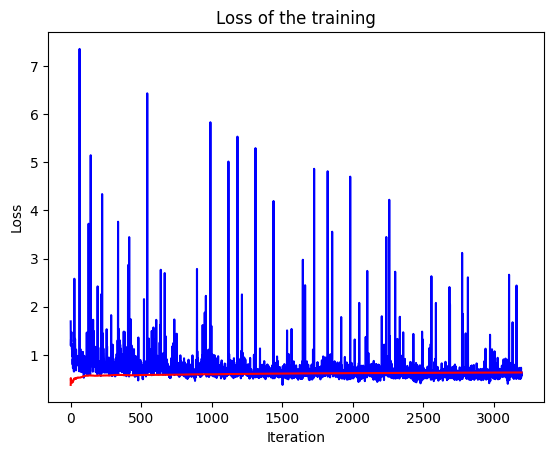

Accuracy: 0.6325
Loss: tensor(0.6304)


In [36]:
losses = [tensor.cpu() for tensor in losses]

plt.plot(losses, c="blue")
plt.plot(accuracies, c="red")
plt.title("Loss of the training")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

print("Accuracy: "+str(accuracies[-1]))
print("Loss: "+str(losses[-1]))

In [37]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloader:
    test_batch = test_batch.to(device)
    pred = model(test_batch).argmax(dim=1)
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    # print("Predicted: " + str(pred) + ", real: "+ str(test_batch.y))
    correct += (pred == test_batch.y).sum()
acc = int(correct) / 300
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6700


[[ 0  0  0  0  0  0]
 [ 0 12 54  0  0  0]
 [ 0  0 93  1  0  0]
 [ 0  0  0 50  0  0]
 [ 0  0  0 44  0  0]
 [ 0  0  0  0  0 46]]


Text(0.5, 47.7222222222222, 'Predicated Label')

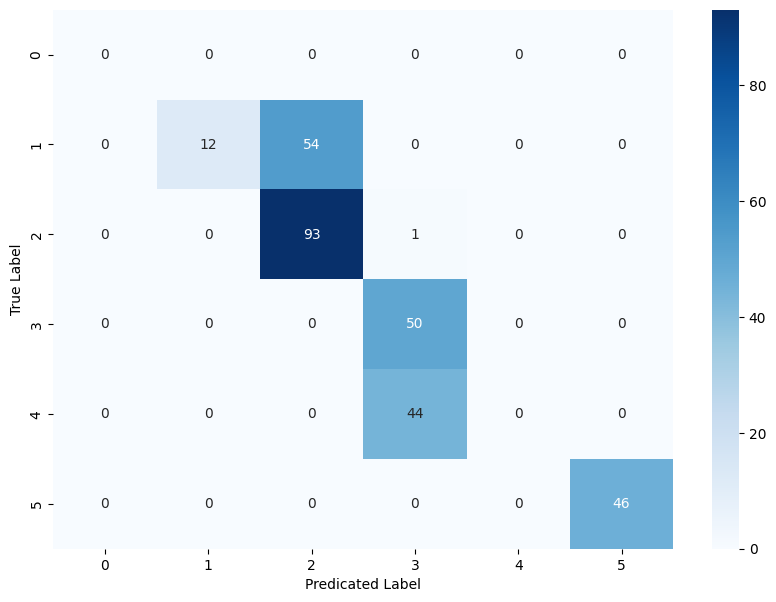

In [38]:
SHAPE_NAMES = [0,1,2,3,4,5]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
print(cm)
# cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

df_cm = pd.DataFrame(cm, index = SHAPE_NAMES,
              columns = SHAPE_NAMES)
plt.figure(figsize = (10,7))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.ylabel('True Label')
plt.xlabel('Predicated Label')